In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting
import nilearn
from connectivity_functions import *
from tree_functions import *
from ni_functions import *
from io_functions import load_data, load_receptor_data
import os
import json
import glob
import inspect
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
import seaborn as sns
import networkx as nx
import abagen
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, leaves_list

/opt/conda/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## Different connectome size plot

In [29]:
project_path = "/workspaces/bha2"
conn_sizes = [183, 391, 568, 729, 964, 1795]
gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

lvlmin = 10
lvlmax = 60
max_crossmod = np.empty((2, len(conn_sizes)))

for conn_size in conn_sizes:
    sc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc"))
    fc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc"))
    fcm, scm = connectome_average(fc_group, sc_group)
    zero_rows_sc = np.where(~scm.any(axis=1))[0]
    scm_nonzero = np.delete(scm, zero_rows_sc, axis=0)
    scm_nonzero = np.delete(scm_nonzero, zero_rows_sc, axis=1)
    fcm_nonzero = np.delete(fcm, zero_rows_sc, axis=0)
    fcm_nonzero = np.delete(fcm_nonzero, zero_rows_sc, axis=1)
    density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (len(scm_nonzero.flatten()))
    fcm_thr = density_threshold(fcm_nonzero, density)
    zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
    fcm_thr_nonzero = np.delete(fcm_thr, zero_rows_fc, axis=0)
    fcm_thr_nonzero = np.delete(fcm_thr_nonzero, zero_rows_fc, axis=1)
    scm_nonzero = np.delete(scm_nonzero, zero_rows_fc, axis=0)
    scm_nonzero = np.delete(scm_nonzero, zero_rows_fc, axis=1)
    
    crossmod_gammas = np.empty((lvlmax - lvlmin, 1))

    for g in gammas_vec:
        tree = json.loads(open(os.path.join(project_path, "data", "results", "n" + str(conn_size),
            "tree_equaldensity_bin_full_g_" + str(g) + ".json")).read())
        crossmod = []
        mod_sc = []
        mod_fc = []
        sim_lvl = []
        for l in range(lvlmin,lvlmax):
            level, labels = level_from_tree(tree, l)
            T = T_from_level(level)
            sim = similarity_mean_level(fcm_thr_nonzero, scm_nonzero, level)
            mod_sc_lvl = modularity(scm_nonzero, T)
            mod_fc_lvl = modularity(fcm_thr_nonzero, T)
            c = pow((sim * mod_sc_lvl * mod_fc_lvl), (1 / 3))
            crossmod.append(c)
        crossmod_gammas = np.hstack((crossmod_gammas, np.array(crossmod).reshape(-1,1)))
        cmod = crossmod_gammas[:,1:]
    max_crossmod[0, conn_sizes.index(conn_size)] = np.max(cmod)
    x,y = np.where(cmod == np.nanmax(cmod))
    max_crossmod[1, conn_sizes.index(conn_size)] = gammas_vec[y[0]]

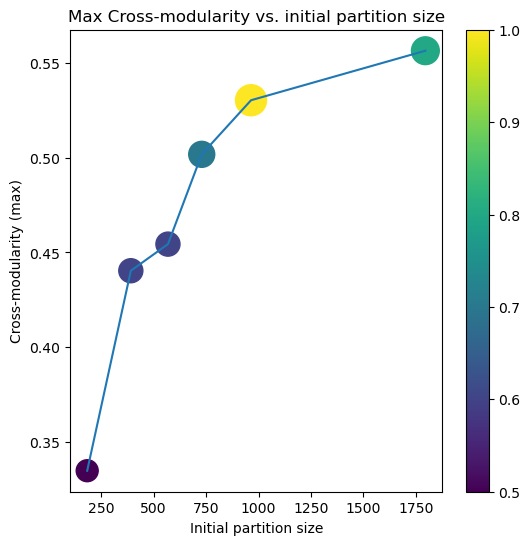

In [37]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.plot(conn_sizes, max_crossmod[0,:])
plt.xlabel("Initial partition size")
plt.ylabel("Cross-modularity (max)")
plt.title("Max Cross-modularity vs. initial partition size")
plt.scatter(conn_sizes, max_crossmod[0,:],s=max_crossmod[1,:]*500, c=max_crossmod[1,:], cmap='viridis')
plt.colorbar()
plt.show()

## Connectome loading

In [3]:
project_path = "/workspaces/bha2"
conn_size = 1795


In [4]:
sc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc"))
fc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc"))

In [5]:
fcm, scm = connectome_average(fc_group, sc_group)
print(fcm.shape)
print(scm.shape)

(1795, 1795)
(1795, 1795)


In [6]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
zero_rows_sc

array([ 124,  623, 1360, 1402, 1523, 1547])

In [7]:
#zero_rows_sc = np.where(~scm.any(axis=1))[0]
scm_nonzero = np.delete(scm, zero_rows_sc, axis=0)
scm_nonzero = np.delete(scm_nonzero, zero_rows_sc, axis=1)
fcm_nonzero = np.delete(fcm, zero_rows_sc, axis=0)
fcm_nonzero = np.delete(fcm_nonzero, zero_rows_sc, axis=1)
print(fcm_nonzero.shape)
print(scm_nonzero.shape)

(1789, 1789)
(1789, 1789)


In [8]:

density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (len(scm_nonzero.flatten()))
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
density


0.09270615627893083

In [9]:

#remove the element zero_rows from fcm and scm
fcm_thr_nonzero = np.delete(fcm_thr, zero_rows_fc, axis=0)
fcm_thr_nonzero = np.delete(fcm_thr_nonzero, zero_rows_fc, axis=1)
scm_nonzero = np.delete(scm_nonzero, zero_rows_fc, axis=0)
scm_nonzero = np.delete(scm_nonzero, zero_rows_fc, axis=1)
fcm_bin = np.where(abs(fcm_thr_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0) 
print(fcm_bin.shape)
print(scm_bin.shape)

(1778, 1778)
(1778, 1778)


Text(0.5, 1.0, 'Structural connectivity matrix')

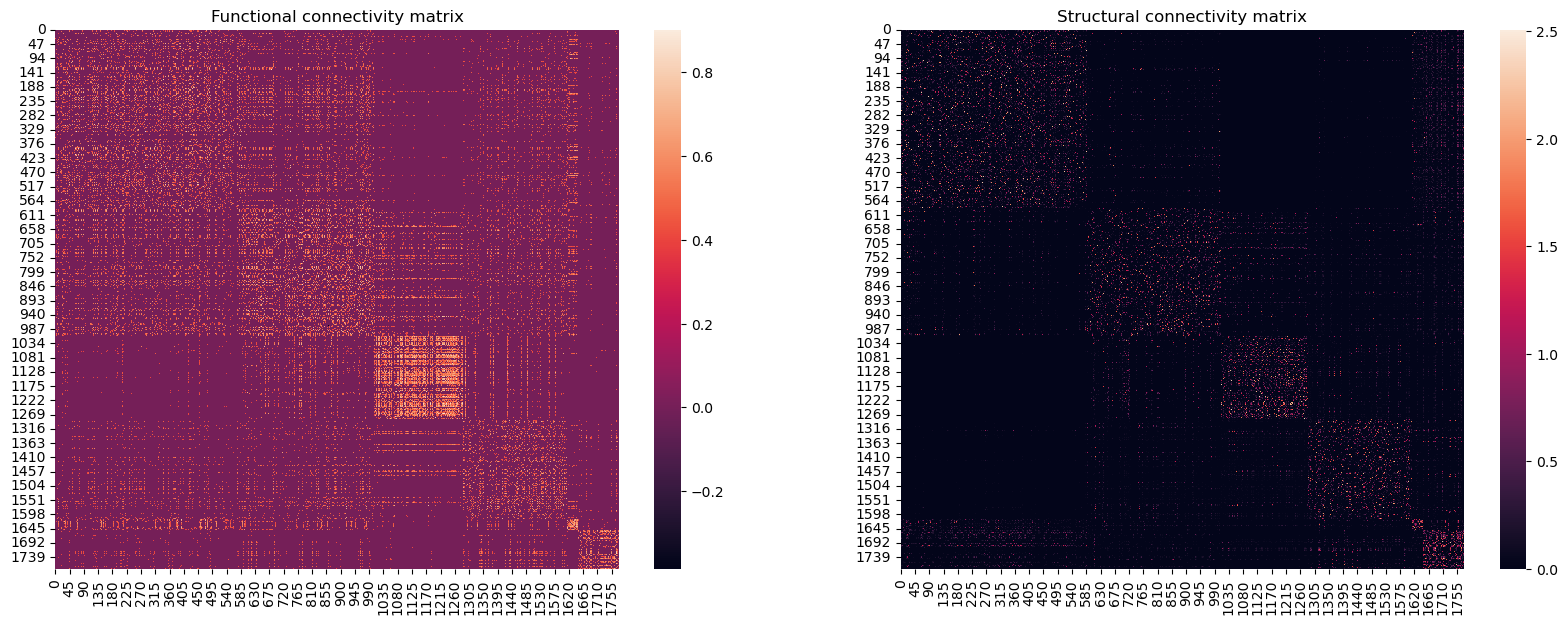

In [10]:
plot, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.heatmap(fcm_thr_nonzero, ax=ax[0])
ax[0].set_title("Functional connectivity matrix")
sns.heatmap(np.log10(scm_nonzero+1), ax=ax[1])
ax[1].set_title("Structural connectivity matrix")

## Generating trees

In [13]:
tree_folder = "tree_network_measures"
tree_min = 2
tree_max = 100
#get the rows with all the elements with zero

for g in np.arange(0, 1.1, 0.1):
    W = matrix_fusion(g, fcm_bin, scm_bin)
    t_dict = tree_dictionary(tree_min, tree_max, W, tree_class = "full")
    json.dump(t_dict, open(os.path.join(project_path, "data", "results", "n" + str(conn_size), "tree_equaldensity_bin_full_g_" + str(round(g, 2)) + ".json"), "w"))


## Crossmodularity

### Using fcm and scm without binarize

In [11]:
lvlmin = 10
lvlmax = 100
crossmod_gammas = np.empty((lvlmax - lvlmin, 1))
mod_sc_gammas = np.empty((lvlmax - lvlmin, 1))
mod_fc_gammas = np.empty((lvlmax - lvlmin, 1))
sim_gammas = np.empty((lvlmax - lvlmin, 1))

for g in np.arange(0, 1.1, 0.1):
    tree = json.loads(open(os.path.join(project_path, "data", "results", "n" + str(conn_size),
        "tree_equaldensity_bin_full_g_" + str(round(g, 2)) + ".json")).read())
    crossmod = []
    mod_sc = []
    mod_fc = []
    sim_lvl = []
    for l in range(lvlmin,lvlmax):
        level, labels = level_from_tree(tree, l)
        T = T_from_level(level)
        sim = similarity_mean_level(fcm_thr_nonzero, scm_nonzero, level)
        mod_sc_lvl = modularity(scm_nonzero, T)
        mod_fc_lvl = modularity(fcm_thr_nonzero, T)
        mod_sc.append(mod_sc_lvl)
        mod_fc.append(mod_fc_lvl)
        sim_lvl.append(sim)
        c = pow((sim * mod_sc_lvl * mod_fc_lvl), (1 / 3))
        crossmod.append(c)
    crossmod_gammas = np.hstack((crossmod_gammas, np.array(crossmod).reshape(-1,1)))
    mod_sc_gammas = np.hstack((mod_sc_gammas, np.array(mod_sc).reshape(-1,1)))
    mod_fc_gammas = np.hstack((mod_fc_gammas, np.array(mod_fc).reshape(-1,1)))
    sim_gammas = np.hstack((sim_gammas, np.array(sim_lvl).reshape(-1,1)))

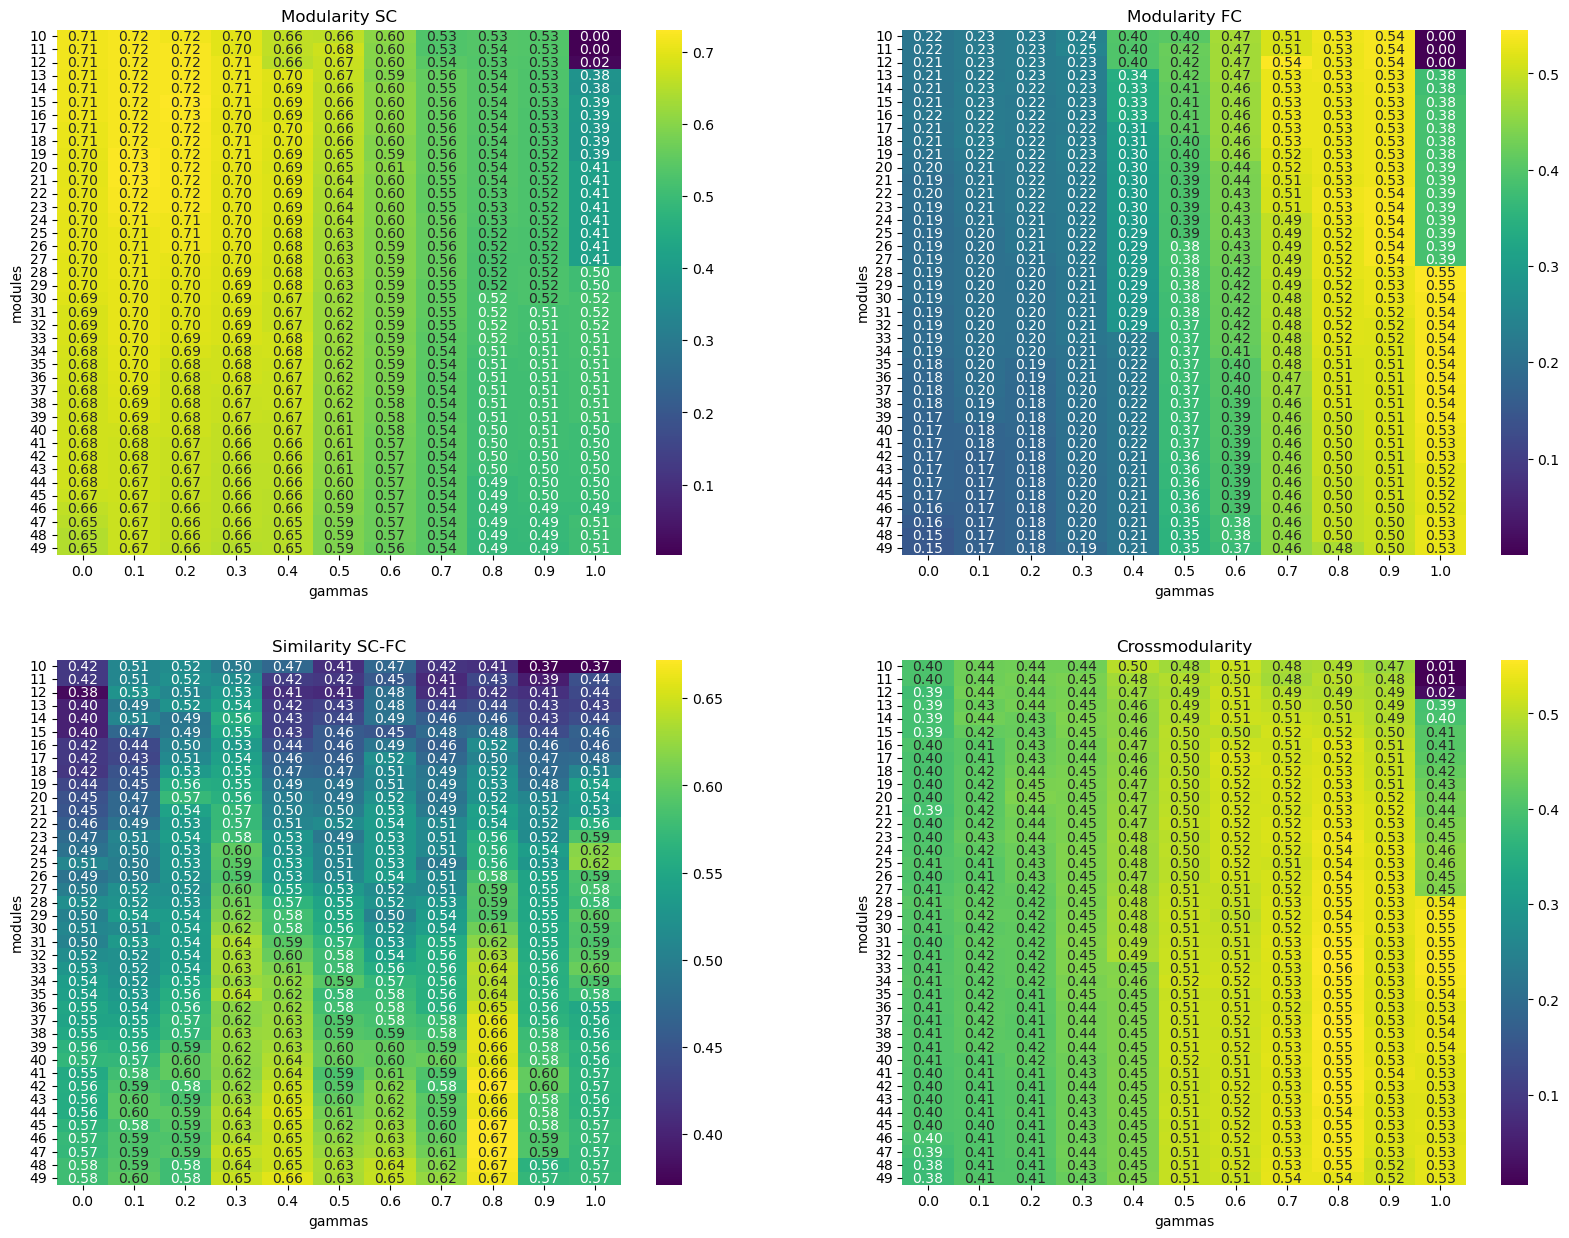

In [16]:
plot, axes = plt.subplots(2, 2, figsize=(20, 15))

h1 = sns.heatmap(mod_sc_gammas[:40,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, 50), 
    annot=True, fmt=".2f", ax=axes[0,0])
_ = h1.set(xlabel='gammas', ylabel='modules')
_ = h1.set_title("Modularity SC")

h2 = sns.heatmap(mod_fc_gammas[:40,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, 50), 
    annot=True, fmt=".2f", ax=axes[0,1])
_ = h2.set(xlabel='gammas', ylabel='modules')
_ = h2.set_title("Modularity FC")

h3 = sns.heatmap(sim_gammas[:40,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, 50), 
    annot=True, fmt=".2f", ax=axes[1,0])
_ = h3.set(xlabel='gammas', ylabel='modules')
_ = h3.set_title("Similarity SC-FC")

h4 = sns.heatmap(crossmod_gammas[:40,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, 50), 
    annot=True, fmt=".2f", ax=axes[1,1])
_ = h4.set(xlabel='gammas', ylabel='modules')
_ = h4.set_title("Crossmodularity")

In [12]:
cmod = crossmod_gammas[:,1:]
x,y = np.where(cmod == np.nanmax(cmod))
gammas_vec = np.arange(0, 1.1, 0.1)
levels_vec = np.arange(lvlmin, lvlmax)
opt_gamma = round(gammas_vec[y][0],2)
opt_level = levels_vec[x][0]
key_pattern = "gamma_" + str(opt_gamma) + "_lvl_" + str(opt_level)
key_pattern

'gamma_0.8_lvl_33'

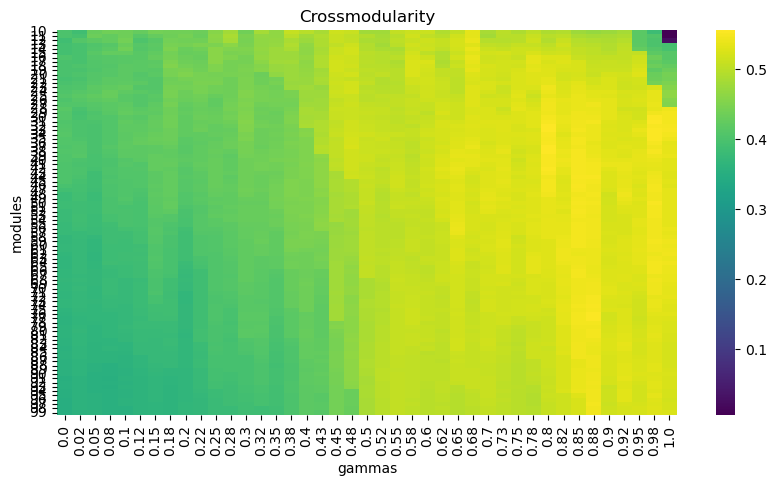

In [173]:
plt.rcParams['figure.figsize'] = [10, 5]
h4 = sns.heatmap(cmod, cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.025, 0.025),2), yticklabels=np.arange(lvlmin, lvlmax), 
    annot=False)
_ = h4.set(xlabel='gammas', ylabel='modules')
_ = h4.set_title("Crossmodularity")

gamma_0.0_lvl_20
gamma_0.02_lvl_22
gamma_0.05_lvl_23
gamma_0.08_lvl_28
gamma_0.1_lvl_10
gamma_0.12_lvl_11
gamma_0.15_lvl_13
gamma_0.18_lvl_11
gamma_0.2_lvl_10
gamma_0.22_lvl_18
gamma_0.25_lvl_17
gamma_0.28_lvl_17
gamma_0.3_lvl_23
gamma_0.32_lvl_15
gamma_0.35_lvl_12
gamma_0.38_lvl_13
gamma_0.4_lvl_13
gamma_0.43_lvl_10
gamma_0.45_lvl_11
gamma_0.48_lvl_10
gamma_0.5_lvl_18
gamma_0.52_lvl_13
gamma_0.55_lvl_13
gamma_0.58_lvl_13
gamma_0.6_lvl_13
gamma_0.62_lvl_11
gamma_0.65_lvl_29
gamma_0.68_lvl_32
gamma_0.7_lvl_28
gamma_0.73_lvl_30
gamma_0.75_lvl_20
gamma_0.78_lvl_20
gamma_0.8_lvl_20
gamma_0.82_lvl_21
gamma_0.85_lvl_31
gamma_0.88_lvl_31
gamma_0.9_lvl_32
gamma_0.92_lvl_24
gamma_0.95_lvl_35
gamma_0.98_lvl_35
gamma_1.0_lvl_32


Text(0, 0.5, 'cmod optimal levels')

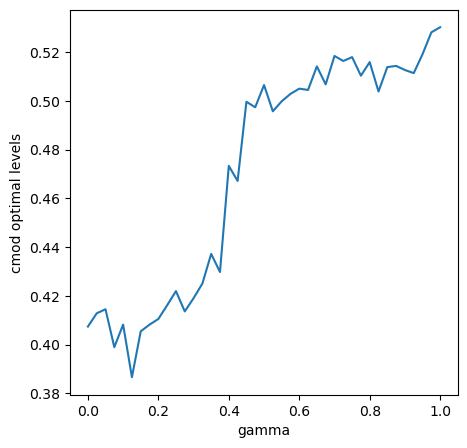

In [103]:
plt.rcParams['figure.figsize'] = [5, 5]
cmod_optimal_levels = []
for i in range(cmod.shape[1]):
    cmod_vec = cmod[:,i]
    x= np.where(cmod_vec == np.nanmax(cmod_vec))
    gammas_vec = np.arange(0, 1.025, 0.025)
    levels_vec = np.arange(lvlmin, lvlmax)
    opt_level = levels_vec[x][0]
    key_pattern = "gamma_" + str(round(gammas_vec[i],2)) + "_lvl_" + str(opt_level)
    cmod_optimal_levels.append(cmod_vec[x][0])
    print(key_pattern)
plt.plot(gammas_vec, cmod_optimal_levels)
plt.xlabel("gamma")
plt.ylabel("cmod optimal levels")

/tmp/ipykernel_4696/2370977820.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


Text(0, 0.5, 'cmod optimal levels')

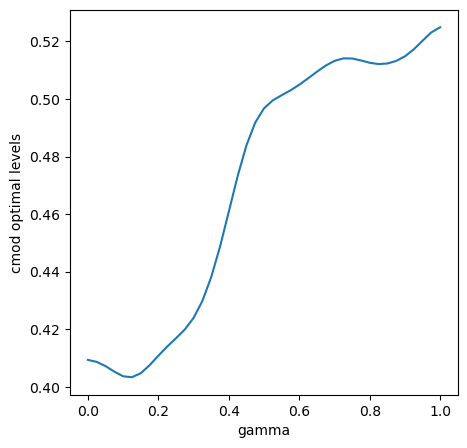

In [104]:

from scipy.ndimage.filters import gaussian_filter1d
ys = gaussian_filter1d(cmod_optimal_levels, sigma=2)
plt.plot(gammas_vec, ys)
plt.xlabel("gamma")
plt.ylabel("cmod optimal levels")

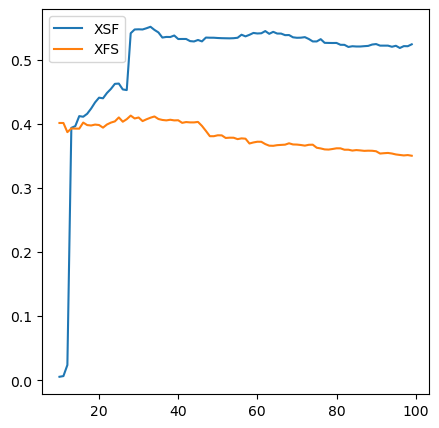

In [88]:
cmod = crossmod_gammas[:,1:]
plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(np.arange(10, 100), cmod[:,10], label="XSF")
plt.plot(np.arange(10, 100), cmod[:,0], label="XFS")
plt.legend()

## Generate brain partition from atlas

In [97]:
tree = json.loads(open(os.path.join(project_path, "data", "results", "n" + str(conn_size),
        "tree_equaldensity_bin_full_g_" + str(opt_gamma) + ".json")).read())
lvl = opt_level
level, labels = level_from_tree(tree, lvl)
atlas_name = "craddock_" + str(conn_size) + ".nii.gz"
atlas = nib.load(os.path.join(project_path, "brain_templates", atlas_name))
atlas_vol = atlas.get_fdata()

atlas_nonzero = np.zeros((atlas_vol.shape[0],atlas_vol.shape[1],atlas_vol.shape[2],1))

old_rois = np.arange(1, atlas_vol.max()+1, dtype=int)
old_rois = np.delete(old_rois, zero_rows_sc)
old_rois = np.delete(old_rois, zero_rows_fc)

for idx, rois in enumerate(old_rois):
    atlas_nonzero[atlas_vol == rois] = idx+1

atlas_nonzero_img = nib.Nifti1Image(atlas_nonzero, affine=atlas.affine)
atlas_moduled = np.zeros((atlas_vol.shape[0],atlas_vol.shape[1],atlas_vol.shape[2]))
for idx,rois in enumerate(level):
    mod = get_module_vol(atlas_nonzero_img, rois, idx+1)
    atlas_moduled = atlas_moduled + mod


img = nib.Nifti1Image(atlas_moduled, affine=atlas.affine)
nib.save(img, os.path.join(project_path, "data", "results", "n" + str(conn_size), "optimal_partition.nii.gz"))

### Compare with RSNs

In [81]:
rsn = nib.load(os.path.join(project_path, "brain_templates", "RSN_networks.nii.gz"))
rsn_labels = np.loadtxt(os.path.join(project_path, "brain_templates", "RSN_networks.txt"), dtype=str)


RSN_table = pd.DataFrame(columns=rsn_labels, index=np.array(["module"+str(i+1) for i in range(len(level))]), dtype=float)

for idx,rois in enumerate(level):
    module_vol = vol = get_module_vol(atlas_nonzero_img, rois)
    rsn_vol = rsn.get_fdata()
    rsn_count = np.zeros((int(rsn_vol.max())))
    for i in range(1, int(rsn_vol.max()) + 1):
        rsn_mask = np.where(rsn_vol == i, 1, 0)
        rsn_count[i - 1] = 2*(rsn_mask*module_vol).sum() / (module_vol.sum()+rsn_mask.sum())
    RSN_table.loc["module"+str(idx+1)] = rsn_count

<AxesSubplot:>

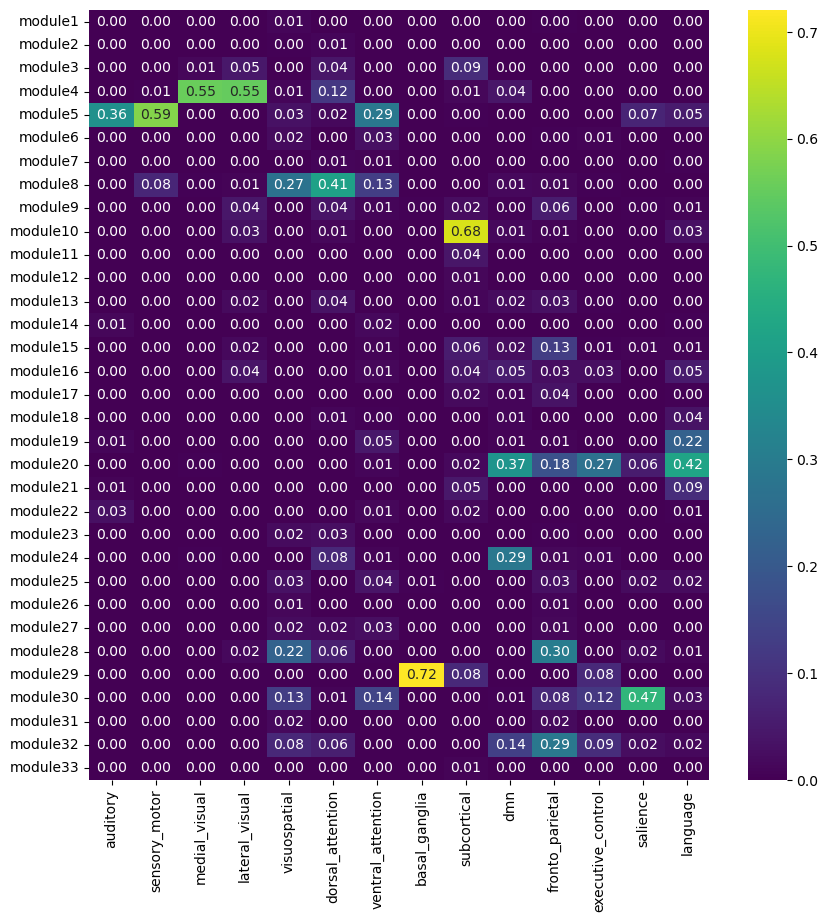

In [83]:
plt.rcParams['figure.figsize'] = [10, 10]
sns.heatmap(RSN_table, cmap='viridis', annot=True, fmt=".2f")

## Generate AHBA matrix

In [ ]:
optimal_partition = nib.load(os.path.join(project_path, "data", "results", "n" + str(conn_size), "optimal_partition.nii.gz"))
expresion = abagen.get_expression_data(optimal_partition)

<AxesSubplot:xlabel='label', ylabel='gene_symbol'>

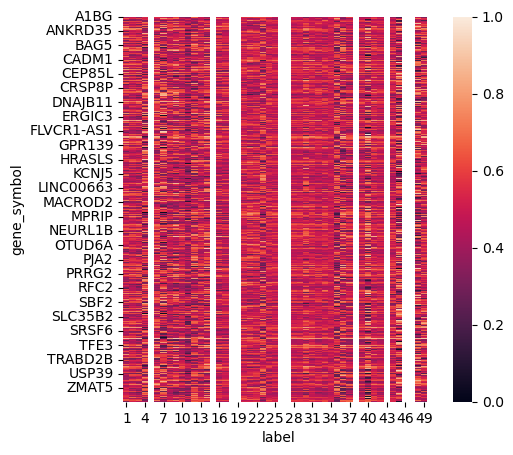

In [ ]:
sns.heatmap(expresion.T)

## Fussioned degree of the 1770x1770 connectivity matrices

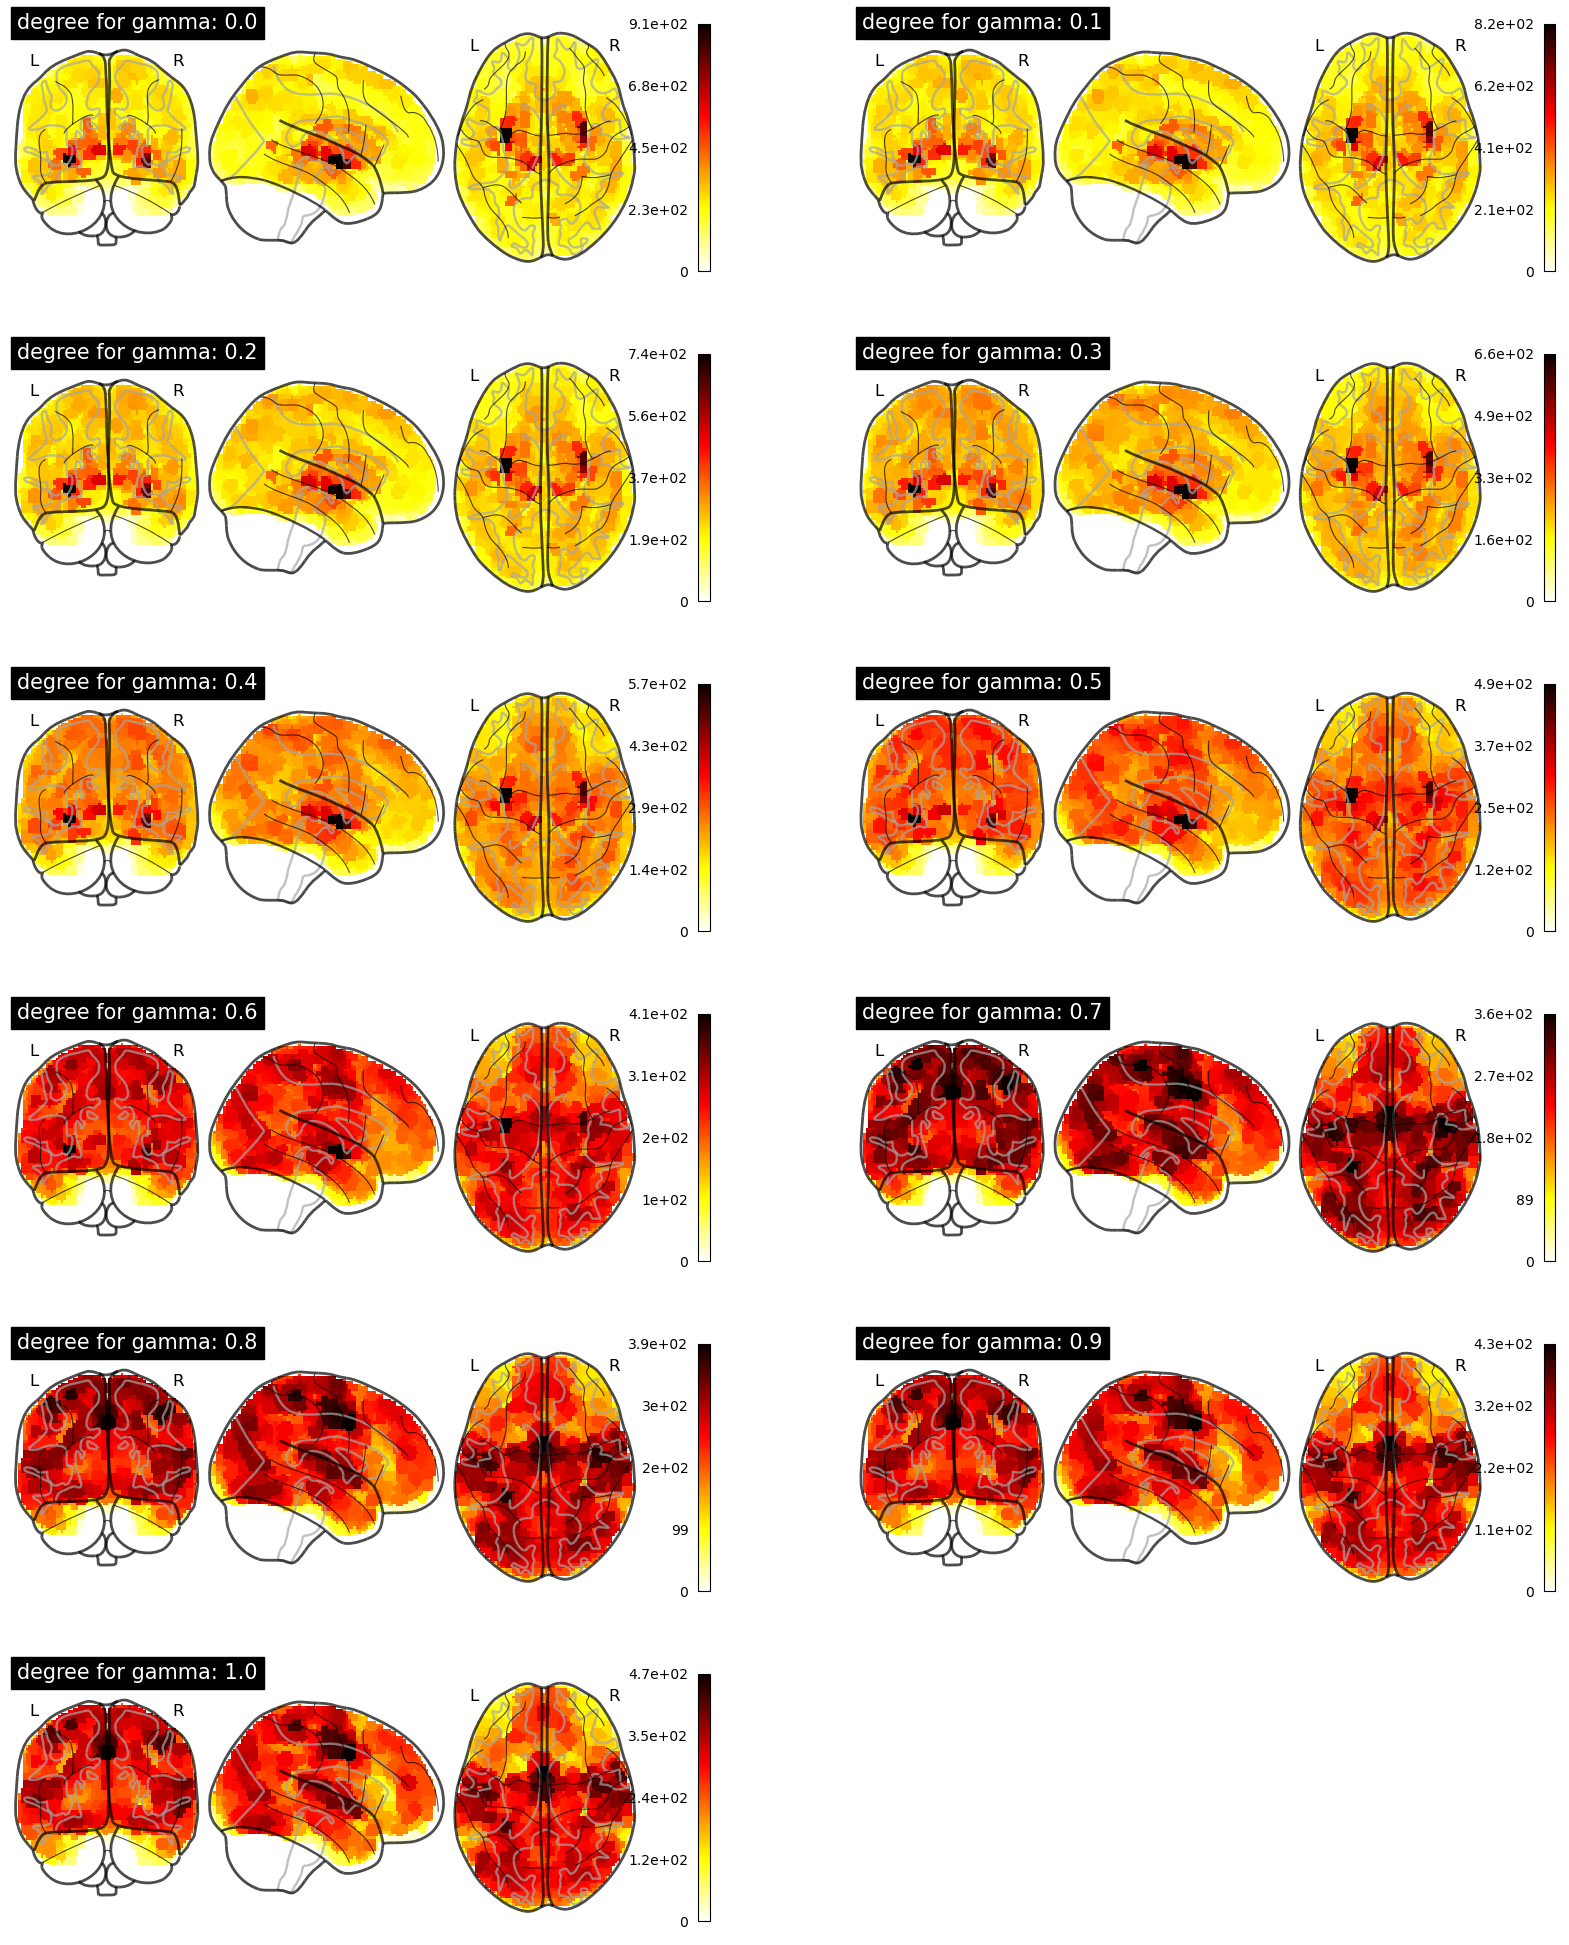

In [19]:
plt.rcParams['figure.figsize'] = [20, 25]

fig = plt.figure()

gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]    
for idx,g in enumerate(gammas_vec):
    ax = fig.add_subplot(6, 2, idx+1)
    cc = abs(((g * abs(fcm_bin)) + ((1 - g) * scm_bin)))
    strength_fullmat = cc.sum(axis=0, dtype=float)
    deg_img = np.zeros(atlas_vol.shape)
    for roi in range(len(strength_fullmat)):
        deg_img[atlas_nonzero == roi+1] = strength_fullmat[roi]
    
    plotting.plot_glass_brain(nib.Nifti1Image(deg_img, affine=atlas.affine), 
        colorbar=True, title="degree for gamma: " + str(g), axes=ax)
    nib.save(nib.Nifti1Image(deg_img, affine=atlas.affine), os.path.join(project_path, "data", "results", "n" + str(conn_size), "degree_g_" + str(g) + ".nii.gz"))
    


<AxesSubplot:xlabel='area', ylabel='degree'>

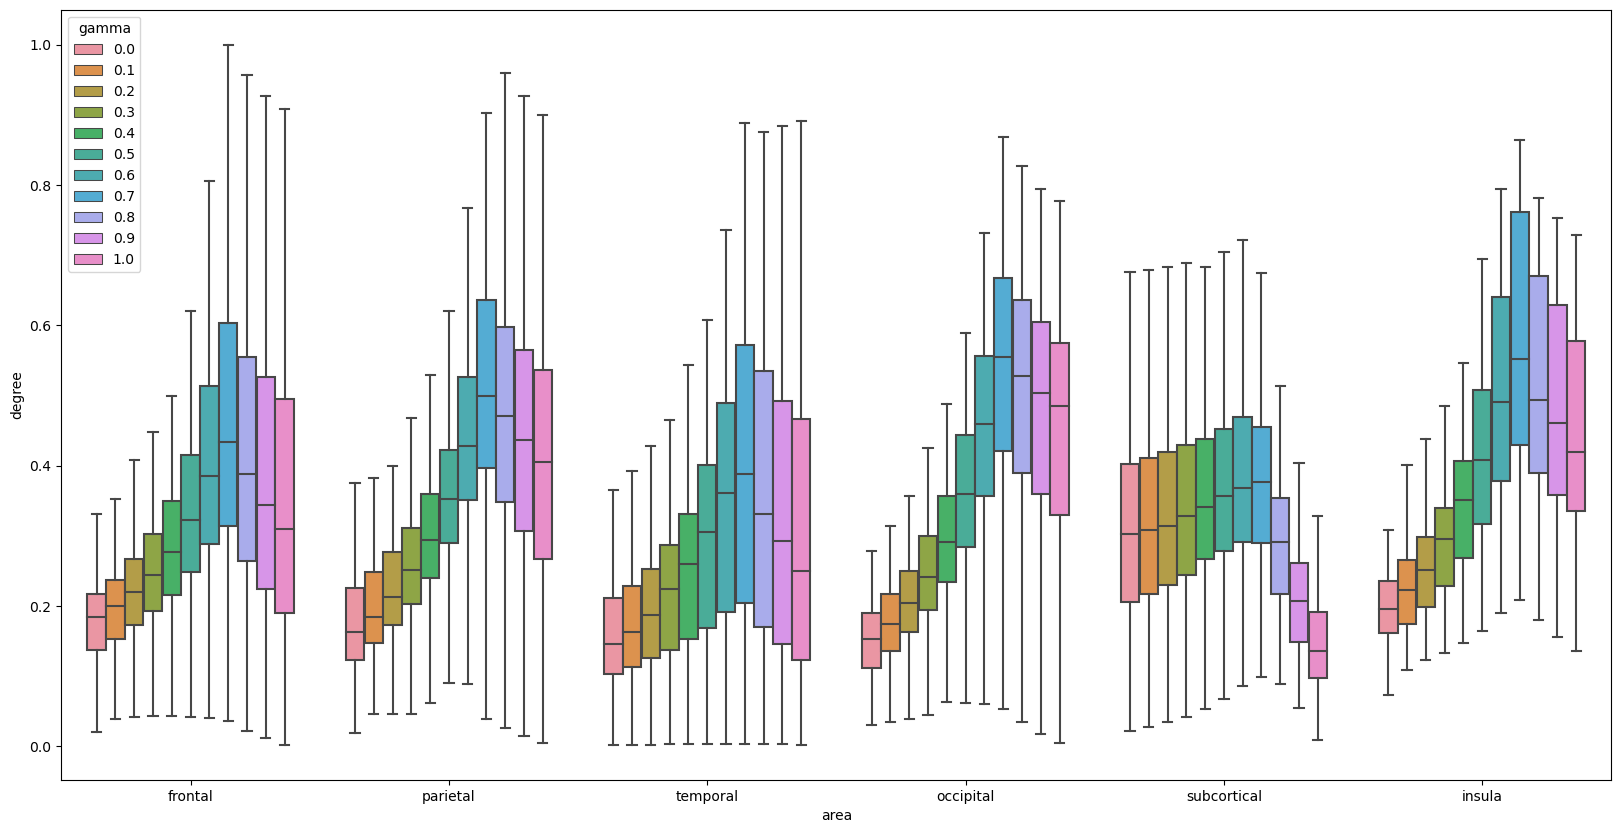

In [20]:
plt.rcParams['figure.figsize'] = [20, 10]

frontal_mask = nib.load(os.path.join(project_path, "brain_templates", "lobule_masks", "Frontal_mask.nii.gz"))
insula_mask = nib.load(os.path.join(project_path, "brain_templates", "lobule_masks", "Insula_mask.nii.gz"))
parietal_mask = nib.load(os.path.join(project_path, "brain_templates", "lobule_masks", "Parietal_mask.nii.gz"))
temporal_mask = nib.load(os.path.join(project_path, "brain_templates", "lobule_masks", "Temporal_mask.nii.gz"))
occipital_mask = nib.load(os.path.join(project_path, "brain_templates", "lobule_masks", "Occipital_mask.nii.gz"))
subcortical_mask = nib.load(os.path.join(project_path, "brain_templates", "lobule_masks", "Subcortical_mask.nii.gz"))

frois = get_atlas_rois_from_mask(frontal_mask,atlas_nonzero_img)
insula = get_atlas_rois_from_mask(insula_mask,atlas_nonzero_img)
parietal = get_atlas_rois_from_mask(parietal_mask,atlas_nonzero_img)
temporal = get_atlas_rois_from_mask(temporal_mask,atlas_nonzero_img)
occipital = get_atlas_rois_from_mask(occipital_mask,atlas_nonzero_img)
subcortical = get_atlas_rois_from_mask(subcortical_mask,atlas_nonzero_img)

fig = plt.figure()
gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]   

strength_vals = []
area_name = []
gamma_val = []

for idx,g in enumerate(gammas_vec):
    cc = abs(((g * abs(fcm_bin)) + ((1 - g) * scm_bin)))
    strength_fullmat = cc.sum(axis=0, dtype=float)

    for roi in frois:
        strength_vals.append(strength_fullmat[int(roi)-1]/np.max(strength_fullmat))
        area_name.append("frontal")
        gamma_val.append(g)

    for roi in parietal:
        strength_vals.append(strength_fullmat[int(roi)-1]/np.max(strength_fullmat))
        area_name.append("parietal")
        gamma_val.append(g)

    for roi in temporal:
        strength_vals.append(strength_fullmat[int(roi)-1]/np.max(strength_fullmat))
        area_name.append("temporal")
        gamma_val.append(g)

    for roi in occipital:
        strength_vals.append(strength_fullmat[int(roi)-1]/np.max(strength_fullmat))
        area_name.append("occipital")
        gamma_val.append(g)

    for roi in subcortical:
        strength_vals.append(strength_fullmat[int(roi)-1]/np.max(strength_fullmat))
        area_name.append("subcortical")
        gamma_val.append(g)

    for roi in insula:
        strength_vals.append(strength_fullmat[int(roi)-1]/np.max(strength_fullmat))
        area_name.append("insula")
        gamma_val.append(g)

df = pd.DataFrame({'degree': strength_vals, 'area': area_name, 'gamma': gamma_val})
sns.boxplot(x="area", y="degree", hue="gamma", data=df, showfliers=False)

## Module volume across the tree

In [101]:
roi_labels = pd.read_csv(os.path.join(project_path, "brain_templates", "craddock_" + str(conn_size) + "_rois.csv"))
roi_labels = roi_labels.drop(zero_rows_fc)
roi_labels = roi_labels.reset_index(drop=True)
roi_labels["ROI_number"] = roi_labels.index

roi_labels.head(5)

ROI_number    X_MNI    Y_MNI    Z_MNI  VOL  Frontal_L  Frontal_R  Insula_L  \
0           0 -13.6670  16.6670 -16.1520   66     1.0000     0.0000         0   
1           1 -46.3140   1.4118   8.8235   51     1.0000     0.0000         0   
2           2  22.5930  44.4200  35.0860   81     0.0000     1.0000         0   
3           3   3.8701 -36.9870  71.5580   77     0.1039     0.8961         0   
4           4 -17.1430  -9.8182  58.7790   77     1.0000     0.0000         0   

   Insula_R  Occipital_L  Occipital_R  Parietal_L  Parietal_R  Subcortical_L  \
0         0          0.0          0.0         0.0         0.0            0.0   
1         0          0.0          0.0         0.0         0.0            0.0   
2         0          0.0          0.0         0.0         0.0            0.0   
3         0          0.0          0.0         0.0         0.0            0.0   
4         0          0.0          0.0         0.0         0.0            0.0   

   Subcortical_R  Temporal_L  Temporal_R  
0            0.0           0           0  
1            0.0           0           0  
2            0.0           0           0  
3            0.0           0           0  
4            0.0           0           0

In [102]:

gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]   
#gammas_vec = [0.0,  0.2, 0.4, 0.6, 0.8, 1.0]   

levels = []
volumes = []
gv = [] 
for idx,g in enumerate(gammas_vec):
        tree = json.loads(open(os.path.join(project_path, "data", "results", "n" + str(conn_size),
                "tree_equaldensity_bin_full_g_" + str(g) + ".json")).read())
        
        for l in range(10,100):
                level, labels = level_from_tree(tree, l)
                for module in level:
                        module_vol = (roi_labels.loc[np.array(module), "VOL"].sum()/8)
                        volumes.append(module_vol)
                        levels.append(l)
                        gv.append(g)
df = pd.DataFrame({'level': levels, 'volume': volumes, 'gamma': gv})


[(10.0, 100.0), (0.0, 6000.0)]

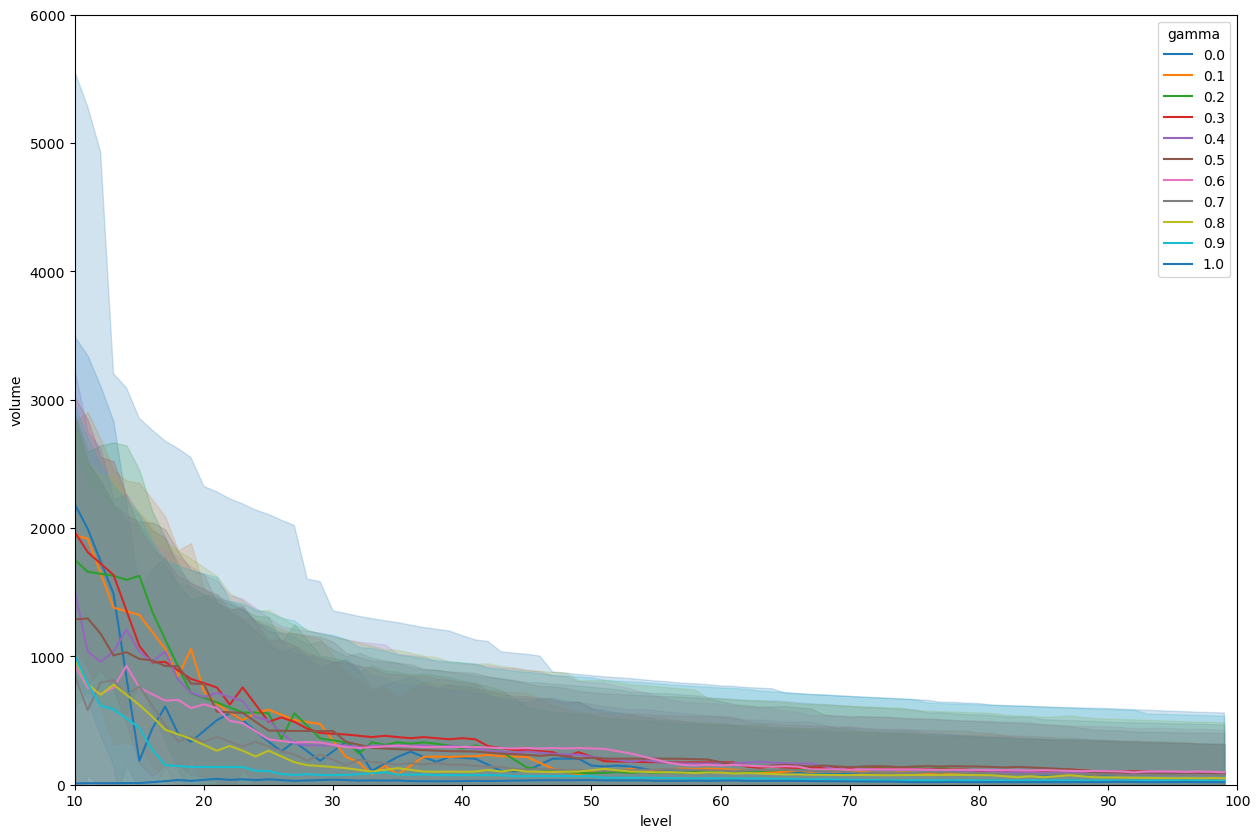

In [103]:
plt.rcParams['figure.figsize'] = [15, 10]

sns.lineplot(data=df, x="level", y="volume", hue="gamma", palette="tab10", ci="sd", estimator=np.median).set(xlim=(10, 100),ylim=(0, 6000))

## Stability accross levels

For getting the stability, I'm going to accumulate 1/module_vol to all the ROIs inside a module, for a range of levels

In [13]:
#Best tree gamma = 0.8
tree_folder = "tree_network_measures"
tree_min = 2
tree_max = 200
#get the rows with all the elements with zero

g=0.8
W = matrix_fusion(g, fcm_bin, scm_bin)
t_dict = tree_dictionary(tree_min, tree_max, W, tree_class = "full")


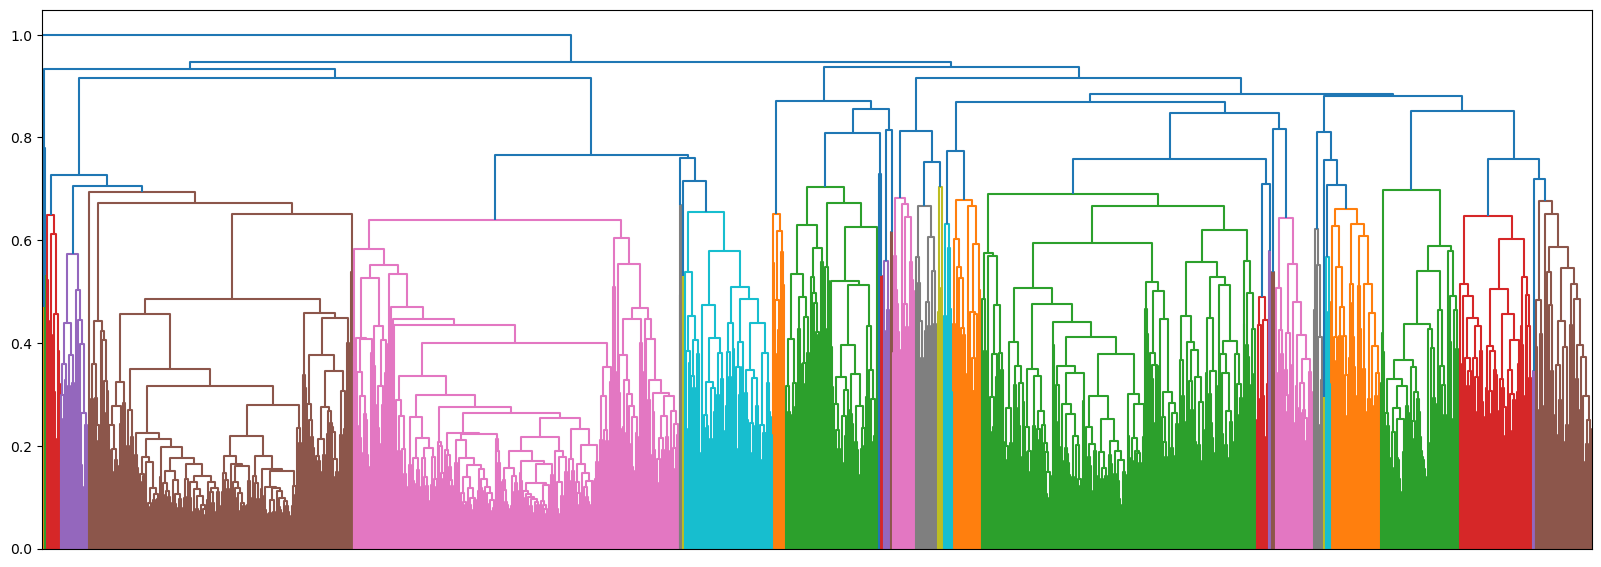

In [115]:
plt.rcParams['figure.figsize'] = [20, 7]

Z = linkage(W, "average")
height_in_tree_sorted = Z[:,2][::-1]

den = dendrogram(Z, color_threshold=height_in_tree_sorted[34-2], no_labels=True)
plt.savefig("dendrogram.svg", format="svg")

(5050,)


101

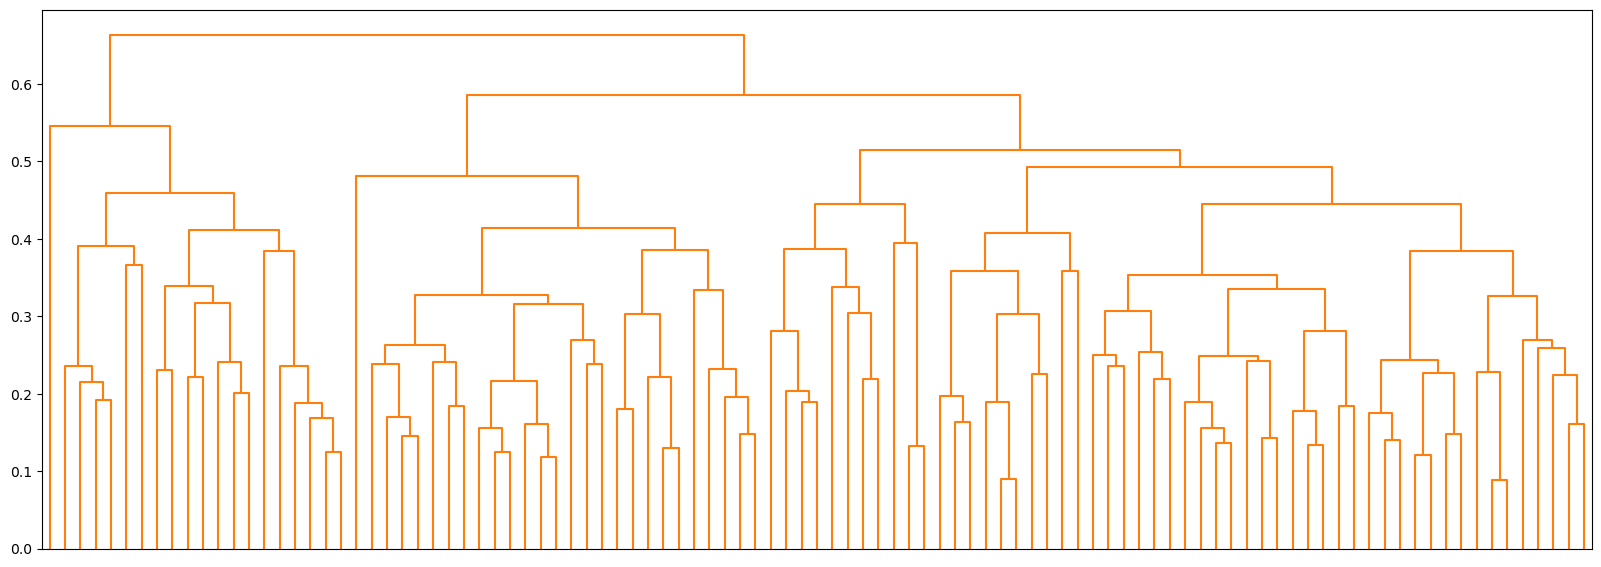

In [160]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

plt.rcParams['figure.figsize'] = [20, 7]
leaves = leaves_list(Z)
height_in_tree_nosorted = np.hstack((1,Z[:,2]))
module_1 = t_dict['lvl_33_mod_' + str(8)]


W_mod = matrix_fusion(g, fcm_bin[module_1,:], scm_bin[module_1,:])
Z_mod = linkage(W_mod, "average")
height_in_tree_sorted_mod = Z[:,2][::-1]
print(W_mod.shape)

# Plot the new dendrogram
den_mod = dendrogram(Z_mod, no_labels=True, color_threshold=height_in_tree_sorted_mod[1])
len(den_mod['leaves'])

Text(0, 0.5, 'Module duration')

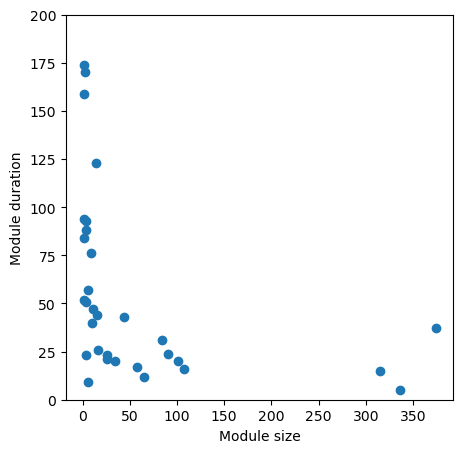

In [715]:
plt.rcParams['figure.figsize'] = [5, 5]

module_duration = []
module_size = []
for module_indices in range(1,opt_level+1):
        module_1 = t_dict['lvl_33_mod_' + str(module_indices)]
        module_presence_in_tree = []
        for l in range(2,200):
                        level, labels = level_from_tree(t_dict, l)
                        for module in level:
                                if module == module_1:
                                        module_presence_in_tree.append(l)
                                        break
        if len(module_1) > 1:
                module_duration.append(len(module_presence_in_tree))
                module_size.append(len(module_1))
        else:
                module_duration.append(1778) #sustituir el hardcodeo
                module_size.append(1)

plt.scatter(module_size, module_duration)
plt.ylim(0, 200)
plt.xlabel("Module size")
plt.ylabel("Module duration")

In [758]:
level, labels = level_from_tree(t_dict, l)
mod14 = level[14]
module_leave_indices = np.where(np.isin(leaves, mod14))[0]
len(height_in_tree_sorted[module_leave_indices])
len(level)

199

Text(0, 0.5, 'Module heights')

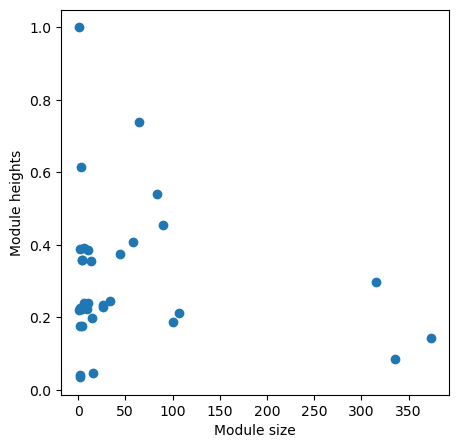

In [765]:
leaves = leaves_list(Z)
height_in_tree_nosorted = np.hstack((1,Z[:,2]))

module_heights = []
module_size = []
for module_indices in range(1,opt_level+1):
        module_1 = t_dict['lvl_33_mod_' + str(module_indices)]
        module_leave_indices = np.where(np.isin(leaves, module_1))[0]
        module_heights.append(np.mean(height_in_tree_nosorted[module_leave_indices]))
        module_size.append(len(module_1))

plt.scatter(module_size, module_heights)
plt.xlabel("Module size")
plt.ylabel("Module heights")

(0.0, 200.0)

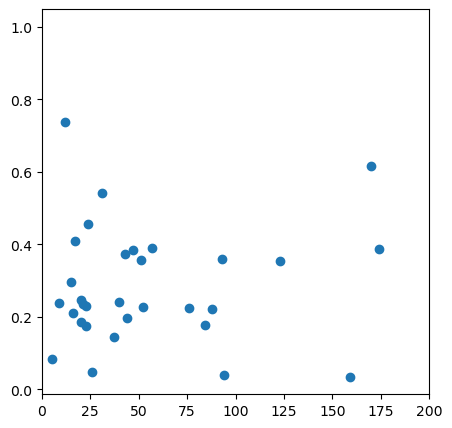

In [769]:
plt.scatter(module_duration, module_heights)
plt.xlim(0, 200)

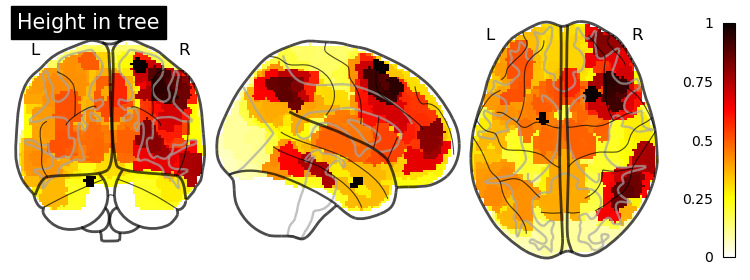

In [727]:

roi_break_heights = np.zeros((atlas_nonzero_img.shape[0],atlas_nonzero_img.shape[1],atlas_nonzero_img.shape[2]))
leaves = leaves_list(Z)
height_in_tree_nosorted = np.hstack((1,Z[:,2]))

for idx in range(len(height_in_tree_nosorted)):
    roi_break_heights = roi_break_heights + get_module_vol(atlas_nonzero_img, leaves[idx], height_in_tree_nosorted[idx])
plotting.plot_glass_brain(nib.Nifti1Image(roi_break_heights, affine=atlas_nonzero_img.affine), 
        colorbar=True, title="Height in tree")

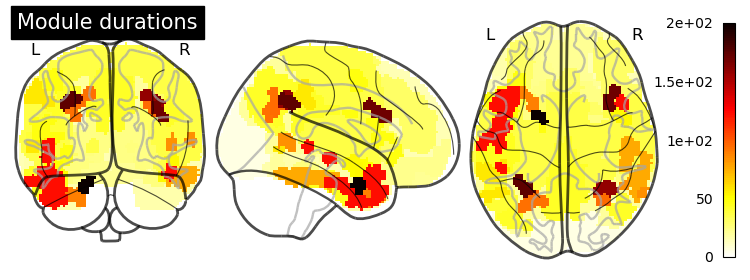

In [702]:
module_durations = np.zeros((atlas_nonzero_img.shape[0],atlas_nonzero_img.shape[1],atlas_nonzero_img.shape[2]))
for idx,module_indices in enumerate(range(1,opt_level+1)):
    module_1 = t_dict['lvl_33_mod_' + str(module_indices)]
    module_durations = module_durations + get_module_vol(atlas_nonzero_img, module_1, module_duration[idx])
plotting.plot_glass_brain(nib.Nifti1Image(module_durations, affine=atlas_nonzero_img.affine), 
        colorbar=True, title="Module durations", vmax=200)

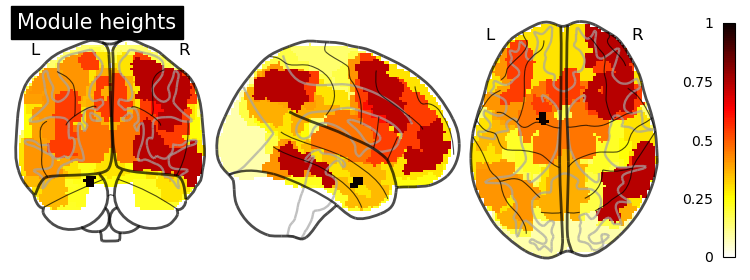

In [766]:
module_heights_img = np.zeros((atlas_nonzero_img.shape[0],atlas_nonzero_img.shape[1],atlas_nonzero_img.shape[2]))
for idx,module_indices in enumerate(range(1,opt_level+1)):
    module_1 = t_dict['lvl_33_mod_' + str(module_indices)]
    module_heights_img = module_heights_img + get_module_vol(atlas_nonzero_img, module_1, module_heights[idx])
plotting.plot_glass_brain(nib.Nifti1Image(module_heights_img, affine=atlas_nonzero_img.affine), 
        colorbar=True, title="Module heights")

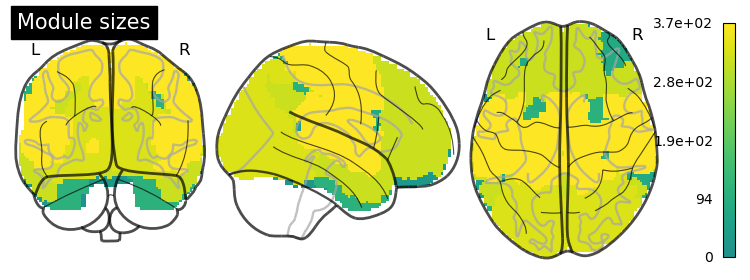

In [776]:
module_sizes = np.zeros((atlas_nonzero_img.shape[0],atlas_nonzero_img.shape[1],atlas_nonzero_img.shape[2]))
for idx,module_indices in enumerate(range(1,opt_level+1)):
    module_1 = t_dict['lvl_33_mod_' + str(module_indices)]
    module_sizes = module_sizes + get_module_vol(atlas_nonzero_img, module_1, module_size[idx])
plotting.plot_glass_brain(nib.Nifti1Image(module_sizes, affine=atlas_nonzero_img.affine), 
        colorbar=True, cmap="viridis", title="Module sizes")

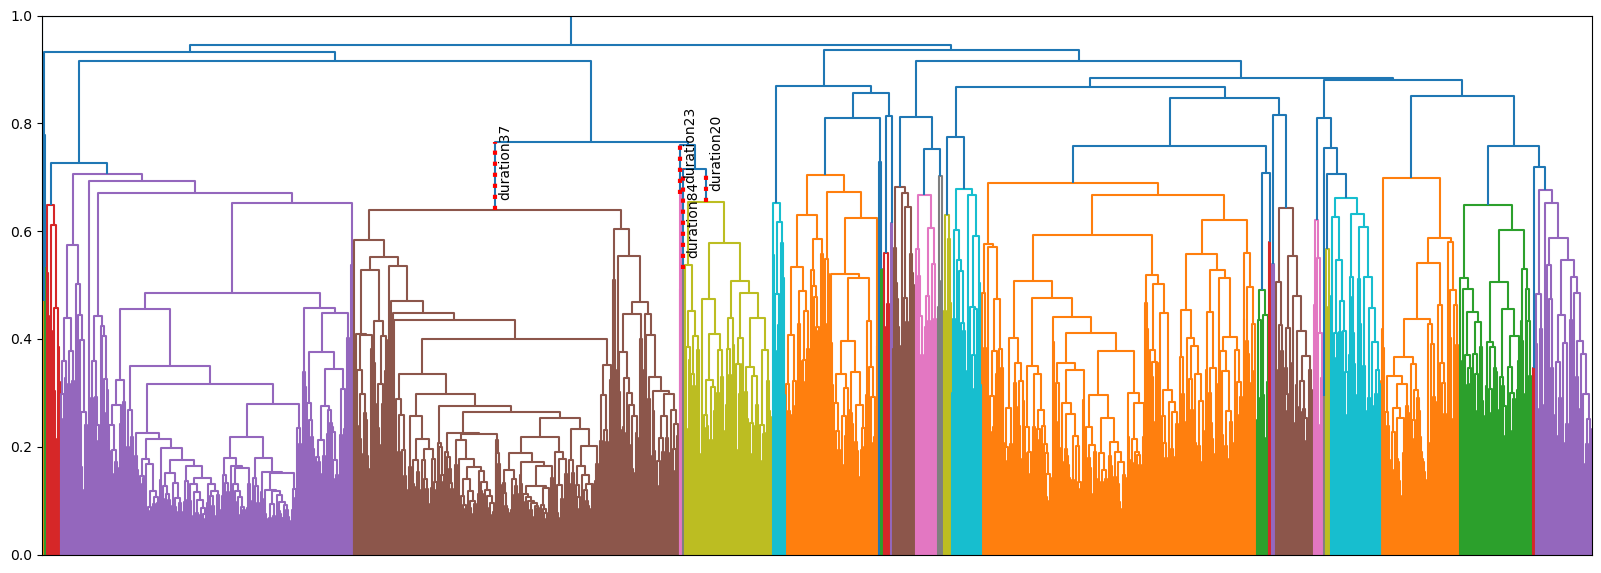

In [100]:
plt.rcParams['figure.figsize'] = [20, 7]

den = dendrogram(Z, color_threshold=height_in_tree_sorted[opt_level-2], no_labels=True)

levels_written = []
for module_indices in range(5,9):
    module_1 = t_dict['lvl_33_mod_' + str(module_indices)]
    module_presence_in_tree = []
    for l in range(2,200):
                    level, labels = level_from_tree(t_dict, l)
                    for module in level:
                            if module == module_1:
                                    module_presence_in_tree.append(l)
                                    break

    lvl_bf_module = min(module_presence_in_tree)-2
    lvl_af_module = max(module_presence_in_tree)-1
    min_height = height_in_tree_sorted[lvl_bf_module]
    max_height = height_in_tree_sorted[lvl_af_module]

    if lvl_af_module<198: #pensar que hacer para repesentar modulos que se rompan despues
        x_loc, y_loc = np.where(np.array(den['dcoord'])==max_height)

        x = den['icoord'][x_loc[2]][y_loc[2]]
        plt.ylim(0,1)
        plt.axvline(x=x, ymin=max_height, ymax=min_height, color='r', ls=':',lw=3)
        plt.annotate('duration'+str(len(module_presence_in_tree)), (x, max_height), textcoords="offset points", xytext=(2,10), ha='left', rotation=90)
        
#plt.plot(x,min_height,'ro')
#
#plt.plot(x,max_height,'ro')
#

374


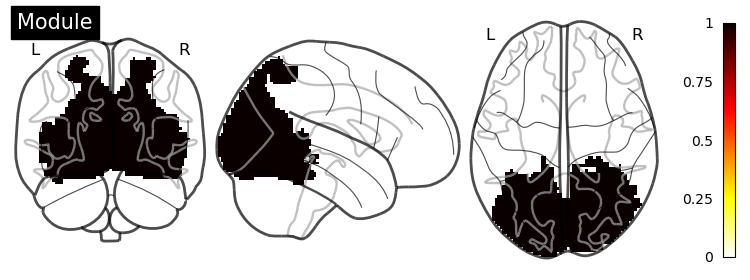

In [777]:
T_test = tree_modules(W,33)
dict_test = level_dictionary(T_test)
print(len(dict_test['lvl_33_mod_4']))
vol = get_module_vol(atlas_nonzero_img, dict_test['lvl_33_mod_4'], value=1.0)
plotting.plot_glass_brain(nib.Nifti1Image(vol, affine=atlas_nonzero_img.affine), 
        colorbar=True, title="Module")

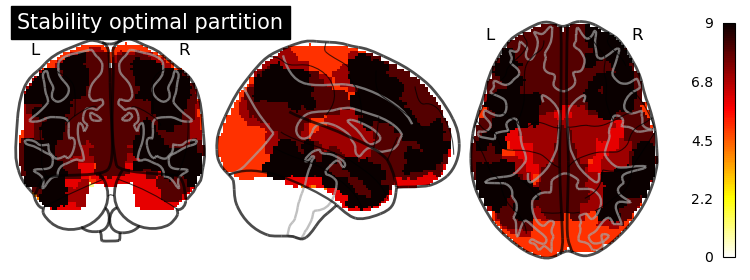

In [607]:
opt_tree = json.loads(open(os.path.join(project_path, "data", "results", "n" + str(conn_size),
        "tree_equaldensity_bin_full_g_" + str(0.8) + ".json")).read())
opt_tree_level, opt_tree_labels = level_from_tree(opt_tree, opt_level)

tree_reduced = json.loads(open(os.path.join(project_path, "data", "results", "n" + str(conn_size),
        "tree_equaldensity_bin_reduced_g_" + str(0.8) + ".json")).read())

partition_stab = np.zeros((atlas_nonzero_img.shape[0],atlas_nonzero_img.shape[1],atlas_nonzero_img.shape[2]))

for opt_mod in opt_tree_level:
    freq_in_tree = np.zeros((len(opt_mod)))
    for l in range(2, opt_level+1):
        reduced_tree_levels, reduced_tree_labels = level_from_tree(tree_reduced, l)
        for reduced_module in reduced_tree_levels:
            roi_intersect = np.isin(opt_mod, reduced_module)
            freq_in_tree[roi_intersect] += 1
    
    mod_freq = get_module_vol(atlas_nonzero_img, opt_mod, freq_in_tree)
    partition_stab = partition_stab + mod_freq

plotting.plot_glass_brain(nib.Nifti1Image(partition_stab, affine=atlas_nonzero_img.affine), 
        colorbar=True, title="Stability optimal partition")

nib.save(nib.Nifti1Image(partition_stab, affine=atlas.affine), os.path.join(project_path, "data", "results", "n" + str(conn_size), "stability_optimal.nii.gz"))


Receptors github -> https://github.com/netneurolab/hansen_receptors

In [72]:
optimal_partition = nib.load(os.path.join(project_path, "data", "results", "n" + str(conn_size), "optimal_partition.nii.gz"))
receptor_dict = load_receptor_data(os.path.join(project_path, "data", "hansen_receptors"), optimal_partition)
receptor_df = generate_receptor_matrix(receptor_dict)

In [74]:
receptor_df.head(3)

5HT1a     5HT1b      5HT2a      5HT4      5HT6      5HTT  \
module1  16.460935 -0.174930  57.286906  2.180717  0.283386  3.199540   
module2  17.009732 -0.376751  49.730820  2.123924  0.305353  3.599723   
module3  43.075031 -0.681662  39.548639  1.820945  0.355280  6.547669   

              A4B2       CB1         D1        D2        DAT       GABAa  \
module1   9.734103  1.078117   8.769906 -0.747895  29.868722  308.788355   
module2   9.742115  1.093868   5.644527 -0.672677  30.110448  425.562097   
module3  10.444338  1.326518  18.499609  0.337303  31.224076  691.485022   

                H3        M1    mGluR5         MU       NAT      NMDA  \
module1   9.986922  2.332394 -1.524953  10.201944 -0.026686  5.695615   
module2  10.397479  2.450329 -1.432850   9.461869 -0.021856  6.160652   
module3  16.130837  3.109986  0.394307  22.913357  0.002212  6.662889   

            VAChT  
module1 -0.541227  
module2 -0.618266  
module3 -0.063935